In [1]:
#                                                    start
#
#                                                      |
#                                                  essay_text

#                                          /          |                    \

#                                                       
#                                       /             |                          \ 
#                                   -                                                
#                         evaluate based           evaluate based                     evaluate based of
#                         on language              on depth of analysis               thought of clarity
# 
#                                      \                |                      /


#                                         \             |                  /
#
#                                                overall evaluation
#
#                                                       |
#                                                      end
#

In [2]:
from langgraph.graph import StateGraph, START, END
# from langchain_groq import ChatGroq
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

True

In [4]:
# model=ChatGroq(model='llama-3.1-8b-instant')
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash')


In [5]:
# model tsting: 
model.invoke('hy').content

'Hi there! How can I help you today?'

In [6]:
class ModelSchema(BaseModel): 
    feedback: str=Field(description="give detaild feedback of essay ")
    score: int=Field(description='give the evaluation score from 0 to 10', ge=0, le=10)

In [7]:
structured_model=model.with_structured_output(ModelSchema)

In [8]:
with open('essay.txt', 'r') as f: 
    essay=f.read()

In [9]:
essay

"Artificial Intelligence in India: Opportunities, Challenges, and the Road Ahead\n\nArtificial Intelligence (AI) is redefining the world by transforming how societies work, how economies grow, and how governments deliver services. For India, a nation with a young population, a rapidly expanding digital infrastructure, and a strong IT ecosystem, AI represents not just a technological advancement but a strategic opportunity to accelerate development, improve governance, and strengthen global competitiveness. As the world moves towards an AI-driven future, India stands at a critical juncture where it must harness this technology responsibly, inclusively, and ethically.\n\nUnderstanding AI and Its Significance for India\n\nArtificial Intelligence refers to the simulation of human intelligence by machines, enabling them to learn, reason, and make decisions. In India, AI is not merely a technological tool; it is increasingly seen as an enabler of socio-economic transformation. India faces st

In [10]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
structured_model.invoke(prompt)


ModelSchema(feedback="This essay provides a highly comprehensive and well-structured analysis of Artificial Intelligence in India. The language quality is exceptional, characterized by sophisticated vocabulary, varied sentence structures, and impeccable grammar and punctuation. The author effectively covers a broad range of topics, including AI's significance, current status, applications across key sectors (agriculture, healthcare, education, governance, finance), opportunities, challenges, and government policies. The essay maintains a balanced perspective, acknowledging both the immense potential and the critical risks associated with AI adoption. The use of clear headings and logical transitions greatly enhances readability and coherence. Specific examples, such as NITI Aayog's projections and various government initiatives (Aadhaar, UPI, IndiaAI Mission), lend credibility and depth to the arguments. Overall, this is an outstanding piece of writing that thoroughly explores the mult

In [11]:
class EvaluationState(TypedDict): 

    essay: str
    
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str

    individual_scores: Annotated[list[int], operator.add]

    overall_feedback: str
    avg_score: int

In [12]:
def language_evaluation(state: EvaluationState): 
    essay=state['essay']
    prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    feedback=structured_model.invoke(prompt)
    return {'language_feedback': feedback.feedback, 'individual_scores':[feedback.score]}

In [13]:
def analysis_evaluation(state: EvaluationState): 
    essay=state['essay']
    prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    feedback=structured_model.invoke(prompt)
    return {'analysis_feedback': feedback.feedback, 'individual_scores':[feedback.score]}

In [14]:
def clarity_evaluation(state: EvaluationState): 
    essay=state['essay']
    prompt = f'Evaluate the thought of clarity of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
    feedback=structured_model.invoke(prompt)
    return {'clarity_feedback': feedback.feedback, 'individual_scores':[feedback.score]}

In [15]:
def overall_evaluation(state: EvaluationState): 

    # overall feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content


    # avg score
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
 
    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [16]:
graph=StateGraph(EvaluationState)

# nodes 
graph.add_node('language_evaluation', language_evaluation)
graph.add_node('analysis_evaluation', analysis_evaluation)
graph.add_node('clarity_evaluation', clarity_evaluation)

graph.add_node('overall_evaluation', overall_evaluation)



# edges: 
graph.add_edge(START,'language_evaluation' )
graph.add_edge(START,'analysis_evaluation' )
graph.add_edge(START,'clarity_evaluation' )

graph.add_edge('language_evaluation', 'overall_evaluation')
graph.add_edge('analysis_evaluation', 'overall_evaluation')
graph.add_edge('clarity_evaluation', 'overall_evaluation')


graph.add_edge('overall_evaluation', END)



# compile: 
workflow=graph.compile()

In [17]:
with open('essay.txt', 'r') as f: 
    essay=f.read()


initial_state={'essay': essay}
final_state=workflow.invoke(initial_state)

In [18]:
final_state

{'essay': "Artificial Intelligence in India: Opportunities, Challenges, and the Road Ahead\n\nArtificial Intelligence (AI) is redefining the world by transforming how societies work, how economies grow, and how governments deliver services. For India, a nation with a young population, a rapidly expanding digital infrastructure, and a strong IT ecosystem, AI represents not just a technological advancement but a strategic opportunity to accelerate development, improve governance, and strengthen global competitiveness. As the world moves towards an AI-driven future, India stands at a critical juncture where it must harness this technology responsibly, inclusively, and ethically.\n\nUnderstanding AI and Its Significance for India\n\nArtificial Intelligence refers to the simulation of human intelligence by machines, enabling them to learn, reason, and make decisions. In India, AI is not merely a technological tool; it is increasingly seen as an enabler of socio-economic transformation. Indi

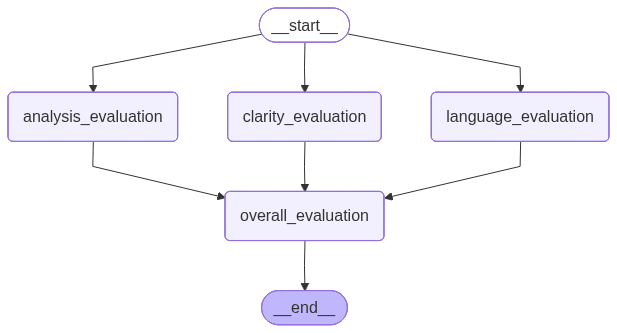

In [19]:
workflow